# Ferrofluid - Part III 

## Table of Contents
1. [Susceptibility with fluctuation formulas](#Susceptibility-with-fluctuation-formulas)
2. [Magnetization curve of a 3D system](#Magnetization-curve-of-a-3D-system)

## Susceptibility with fluctuation formulas

In this part we want to calculate estimators for the initial susceptibility, i.e. the susceptibility at zero external magnetic field. One could carry out several simulations with different external magnetic field strenghts and get the initial susceptibility by fitting a line to the results. We want to go a more elegant way by using fluctuation formulas known from statistical mechanics.
In three dimensions the initial susceptibility $\chi_{init}$ can be calculated with zero field simulations through

\begin{equation}
    \chi_{init} = \frac{V \cdot \mu_0}{3 \cdot k_B T} \left( \langle \boldsymbol{M}^2 \rangle - \langle \boldsymbol{M} \rangle^2 \right) = \frac{\mu_0}{3 \cdot k_B T \cdot V} \left( \langle \boldsymbol{\mu}_{tot}^2 \rangle - \langle \boldsymbol{\mu}_{tot} \rangle^2 \right)
\end{equation}

where $\boldsymbol{M}$ is the magnetization vector. In direction $i$ it reads

\begin{equation}
    M_i = \frac{1}{V} \Bigg\langle \sum_{j=1}^N \mu_j^i \Bigg\rangle
\end{equation}

where $\mu_j^i$ is the $j$ th dipole moment in direction $i$.

In this part we want to consider a three dimensional ferrofluid system and compare our results with them of Ref. [1].

First we import all necessary packages

In [1]:
from __future__ import print_function

import espressomd
from espressomd.magnetostatics import DipolarP3M
import numpy as np

Now we setting up all necessary simulation parameters

In [2]:
lj_sigma=1
lj_epsilon=1
lj_cut = 2**(1./6.) * lj_sigma

# magnetic field constant
mu_0 = 1.

# Particles
N = 1000

# Volume fraction
# phi = rho * 4. / 3. * np.pi * ( lj_sigma / 2 )**3.
phi = 0.0262

# Dipolar interaction parameter lambda = mu_0 m^2 /(4 pi sigma^3 kT)
dip_lambda = 3.

# Temperature
kT =1.0

# Friction coefficient
gamma=1.0

# Time step
dt =0.01

# box size 3d
box_size = (N * np.pi * 4./3. * (lj_sigma / 2.)**3. / phi)**(1./3.)

# dipole moment
dipm = np.sqrt(dip_lambda*4*np.pi*lj_sigma**3*kT / mu_0)

and the system (for more details see Part I)

In [3]:
system=espressomd.System(box_l=(box_size,box_size,box_size)) 
system.time_step=dt
system.thermostat.set_langevin(kT=kT,gamma=gamma)
system.set_random_state_PRNG()

# Lennard Jones interaction
system.non_bonded_inter[0,0].lennard_jones.set_params(epsilon=lj_epsilon,sigma=lj_sigma,cutoff=lj_cut, shift="auto")

# Random dipole moments
dip_phi=np.random.random((N,1)) *2. * np.pi
dip_cos_theta = 2*np.random.random((N,1)) -1
dip_sin_theta = np.sin(np.arccos(dip_cos_theta))
dip = np.hstack((
   dip_sin_theta *np.sin(dip_phi),
   dip_sin_theta *np.cos(dip_phi),
   dip_cos_theta))

# Random positions in system volume
pos = box_size * np.random.random((N,3))

# Add particles
system.part.add(pos=pos, rotation=N*[(1,1,1)], dip=dip)

# Remove overlap between particles by means of the steepest descent method
system.integrator.set_steepest_descent(
    f_max=0,gamma=0.1,max_displacement=0.05)

while system.analysis.energy()["total"] > 5*kT*N:
    system.integrator.run(20)

# Switch to velocity Verlet integrator
system.integrator.set_vv()

# tune verlet list skin
system.cell_system.tune_skin(min_skin=0.4, max_skin=2., tol=0.2, int_steps=100)

# Setup dipolar P3M and dipolar layer correction
system.actors.add(DipolarP3M(accuracy=5E-4,prefactor=dip_lambda*lj_sigma**3*kT))

# tune verlet list skin again
system.cell_system.tune_skin(min_skin=0.4, max_skin=2., tol=0.2, int_steps=100)

b'Dipolar P3M tune parameters: Accuracy goal = 5.00000e-04 prefactor = 3.00000e+00\nSystem: box_l = 2.71372e+01 # charged part = 1000 Sum[q_i^2] = 1.00000e+03\nDmesh cao Dr_cut_iL   Dalpha_L     Derr         Drs_err    Dks_err    time [ms]\n8    3   4.24107e-01 5.17041e+00 4.99109e-04 3.535e-04 3.523e-04 28      \n8    2   4.29986e-01 5.07155e+00 8.63822e-04 3.535e-04 7.882e-04 accuracy not achieved\n8    4   3.98912e-01 5.62861e+00 4.98339e-04 3.535e-04 3.512e-04 30      \n10   3   3.84347e-01 5.92221e+00 4.96679e-04 3.535e-04 3.489e-04 24      \n10   2   4.24107e-01 5.17041e+00 6.18962e-04 3.535e-04 5.081e-04 accuracy not achieved\n10   4   3.58668e-01 6.50095e+00 4.94581e-04 3.535e-04 3.459e-04 20      \n10   5   3.44587e-01 6.85692e+00 4.96267e-04 3.535e-04 3.483e-04 22      \n12   4   3.26444e-01 7.36345e+00 4.95487e-04 3.535e-04 3.472e-04 18      \n12   3   3.53064e-01 6.63901e+00 4.99418e-04 3.535e-04 3.527e-04 19      \n12   5   3.12434e-01 7.79719e+00 4.98429e-04 3.535e-04 3.5

0.7000000000000001

Now we equilibrate for a while

In [4]:
print("Equilibration...")
for i in range(30):
  system.integrator.run(1000)
  print("Dipolar energy: %.2f" % system.analysis.energy()["dipolar"])
  print("progress: {:6.2f} %".format((float(i)+1)/30 * 100))
print("Equilibration done")

Equilibration...
Dipolar energy: -1127.21
progress:   3.33 %
Dipolar energy: -1101.69
progress:   6.67 %
Dipolar energy: -1093.96
progress:  10.00 %
Dipolar energy: -1110.64
progress:  13.33 %
Dipolar energy: -1111.75
progress:  16.67 %
Dipolar energy: -1046.52
progress:  20.00 %
Dipolar energy: -932.92
progress:  23.33 %
Dipolar energy: -1075.62
progress:  26.67 %
Dipolar energy: -1115.48
progress:  30.00 %
Dipolar energy: -990.71
progress:  33.33 %
Dipolar energy: -1050.24
progress:  36.67 %
Dipolar energy: -1084.22
progress:  40.00 %
Dipolar energy: -1104.30
progress:  43.33 %
Dipolar energy: -1179.15
progress:  46.67 %
Dipolar energy: -1082.89
progress:  50.00 %
Dipolar energy: -1098.76
progress:  53.33 %
Dipolar energy: -1056.72
progress:  56.67 %
Dipolar energy: -1060.00
progress:  60.00 %
Dipolar energy: -1183.64
progress:  63.33 %
Dipolar energy: -1117.70
progress:  66.67 %
Dipolar energy: -1041.98
progress:  70.00 %
Dipolar energy: -1036.25
progress:  73.33 %
Dipolar energy: -

As we need the magnetization of our system, we import <tt>MagneticDipoleMoment</tt> from <tt>observables</tt> which returns us the total dipole moment of the system which is the magnetization times the volume of the system.

In [5]:
from espressomd.observables import MagneticDipoleMoment
dipm_tot_calc = MagneticDipoleMoment(ids=system.part[:].id)

Now we set the desired number of loops for the sampling

In [6]:
# Sampling
loops = 1000

and sample the first and second moment of the magnetization or total dipole moment, by averaging over all total dipole moments occuring during the simulation

In [7]:
print('Sampling ...')
# calculate initial total dipole moment
dipm_tot_temp = dipm_tot_calc.calculate()

# initiate variables for sum of first and second moment of total dipole moment
dipm_tot_sum = dipm_tot_temp
dipm_tot_2_sum = np.square(dipm_tot_temp)

# sample dipole moment
for i in range(loops):
    system.integrator.run(100)
    dipm_tot_temp = dipm_tot_calc.calculate()
    
    # add current dipole moment
    dipm_tot_sum = np.sum((dipm_tot_sum, dipm_tot_temp), axis=0)
    dipm_tot_2_sum = np.sum((dipm_tot_2_sum, np.square(dipm_tot_temp)), axis=0)
    print("progress: {:6.2f} %".format((float(i)+1)/loops * 100))
    
# calculate average first and second moment of total dipole moment
dipm_tot = dipm_tot_sum / loops
dipm_tot_2 = dipm_tot_2_sum / loops
print("Sampling done")

Sampling ...
progress:   0.10 %
progress:   0.20 %
progress:   0.30 %
progress:   0.40 %
progress:   0.50 %
progress:   0.60 %
progress:   0.70 %
progress:   0.80 %
progress:   0.90 %
progress:   1.00 %
progress:   1.10 %
progress:   1.20 %
progress:   1.30 %
progress:   1.40 %
progress:   1.50 %
progress:   1.60 %
progress:   1.70 %
progress:   1.80 %
progress:   1.90 %
progress:   2.00 %
progress:   2.10 %
progress:   2.20 %
progress:   2.30 %
progress:   2.40 %
progress:   2.50 %
progress:   2.60 %
progress:   2.70 %
progress:   2.80 %
progress:   2.90 %
progress:   3.00 %
progress:   3.10 %
progress:   3.20 %
progress:   3.30 %
progress:   3.40 %
progress:   3.50 %
progress:   3.60 %
progress:   3.70 %
progress:   3.80 %
progress:   3.90 %
progress:   4.00 %
progress:   4.10 %
progress:   4.20 %
progress:   4.30 %
progress:   4.40 %
progress:   4.50 %
progress:   4.60 %
progress:   4.70 %
progress:   4.80 %
progress:   4.90 %
progress:   5.00 %
progress:   5.10 %
progress:   5.20 %

progress:  43.20 %
progress:  43.30 %
progress:  43.40 %
progress:  43.50 %
progress:  43.60 %
progress:  43.70 %
progress:  43.80 %
progress:  43.90 %
progress:  44.00 %
progress:  44.10 %
progress:  44.20 %
progress:  44.30 %
progress:  44.40 %
progress:  44.50 %
progress:  44.60 %
progress:  44.70 %
progress:  44.80 %
progress:  44.90 %
progress:  45.00 %
progress:  45.10 %
progress:  45.20 %
progress:  45.30 %
progress:  45.40 %
progress:  45.50 %
progress:  45.60 %
progress:  45.70 %
progress:  45.80 %
progress:  45.90 %
progress:  46.00 %
progress:  46.10 %
progress:  46.20 %
progress:  46.30 %
progress:  46.40 %
progress:  46.50 %
progress:  46.60 %
progress:  46.70 %
progress:  46.80 %
progress:  46.90 %
progress:  47.00 %
progress:  47.10 %
progress:  47.20 %
progress:  47.30 %
progress:  47.40 %
progress:  47.50 %
progress:  47.60 %
progress:  47.70 %
progress:  47.80 %
progress:  47.90 %
progress:  48.00 %
progress:  48.10 %
progress:  48.20 %
progress:  48.30 %
progress:  4

progress:  86.40 %
progress:  86.50 %
progress:  86.60 %
progress:  86.70 %
progress:  86.80 %
progress:  86.90 %
progress:  87.00 %
progress:  87.10 %
progress:  87.20 %
progress:  87.30 %
progress:  87.40 %
progress:  87.50 %
progress:  87.60 %
progress:  87.70 %
progress:  87.80 %
progress:  87.90 %
progress:  88.00 %
progress:  88.10 %
progress:  88.20 %
progress:  88.30 %
progress:  88.40 %
progress:  88.50 %
progress:  88.60 %
progress:  88.70 %
progress:  88.80 %
progress:  88.90 %
progress:  89.00 %
progress:  89.10 %
progress:  89.20 %
progress:  89.30 %
progress:  89.40 %
progress:  89.50 %
progress:  89.60 %
progress:  89.70 %
progress:  89.80 %
progress:  89.90 %
progress:  90.00 %
progress:  90.10 %
progress:  90.20 %
progress:  90.30 %
progress:  90.40 %
progress:  90.50 %
progress:  90.60 %
progress:  90.70 %
progress:  90.80 %
progress:  90.90 %
progress:  91.00 %
progress:  91.10 %
progress:  91.20 %
progress:  91.30 %
progress:  91.40 %
progress:  91.50 %
progress:  9

Now we can calculate the estimator of the initial susceptibility $\chi_{init}$

In [8]:
# susceptibility in 3d system
chi = mu_0 /(box_size**3. * 3.) * ( np.sum(dipm_tot_2 * dipm**2.) - np.sum(np.square(dipm_tot * dipm)) )

and print the result

In [9]:
print('chi = %.4f' % chi)

chi = 0.8351


Copared with table 1 in Ref. [1] they should be very similar

Now we want to compare the result with the theoretically expectations.
At first with the simple Langevin susceptibility

In [10]:
chi_L = 8. * dip_lambda * phi
print('chi_L = %.4f' % chi_L)

chi_L = 0.6288


and at second with the more advanced one (see Ref. [1] eq. (6)) which has a cubic accuracy in $\chi_L$ and reads

\begin{equation}
    \chi = \chi_L \left( 1 + \frac{\chi_L}{3} + \frac{\chi_L^2}{144} \right)
\end{equation}



In [11]:
chi_L = 8. * dip_lambda * phi
chi_I = chi_L * ( 1 + chi_L / 3. + chi_L**2. / 144. )
print('chi_I = %.4f' % chi_I)

chi_I = 0.7623


Both of them should be smaller than our result, but the second one should be closer to our one.

## Magnetization curve of a 3D system

At the end of this tutorial we now want to sample the magnetization curve of a three dimensional system and compare the results with analytical solutions. Again we will compare with the Langevin function but also with the approximation of Ref. [2] (see also Ref. [1] for the right coefficients) which takes the dipole-dipole interaction into account. For this approximation, which is a modified mean-field theory, the Langevin parameter $\alpha$ is replaced by

\begin{equation}
    \alpha' = \alpha + \chi_L~L(\alpha) + \frac{\chi_L^{2}}{16} L(\alpha) \frac{d L(\alpha)}{d\alpha}
\end{equation}

where $\chi_L$ is the Langevin susceptibility

\begin{equation}
   \chi_L = \frac{N}{V}\frac{\mu_0 \mu^2}{3k_BT} = 8 \cdot \lambda \cdot \phi
\end{equation}

Analogous to **part II** we start at zero external magnetic field and increase the external field successively. At every value of the external field we sample the total dipole moment which is propotional to the magnetization.

First we create a list of values of the Langevin parameter $\alpha$

In [12]:
alphas = np.arange(0,10).tolist()

and sample for each value in this list the total dipole moment / magnetization of the system for a while

In [13]:
# remove all constraints
system.constraints.clear()

# list of magnetization in field direction
magnetization = []

# number of loops for sampling
loops = 100

for alpha in alphas:
    print("Sample for alpha = {}".format(alpha))
    H_dipm = (alpha*kT)
    H_field = [H_dipm,0,0]
    print("Set magnetic field constraint...")
    H_constraint = espressomd.constraints.HomogeneousMagneticField(H=H_field)
    system.constraints.add(H_constraint)
    print("done")
    
    # Equilibration
    print("Equilibration...")
    for i in range(30):
        system.integrator.run(1000)
        print("Dipolar energy: %.2f" % system.analysis.energy()["dipolar"])
        print("progress: {:6.2f} %".format((float(i)+1)/30 * 100))
    print("Equlilibration done \n")
    
    # Sampling
    print("Sampling...")
    magn_temp = 0
    for i in range(loops):
        system.integrator.run(100)
        magn_temp += dipm_tot_calc.calculate()[0]
        print("progress: {:6.2f} %".format((float(i)+1)/loops * 100))
    
    # save average magnetization
    magnetization.append(magn_temp / loops)
    print("Sampling for alpha = {} done \n".format(alpha))
    print("magnetizations = {}".format(magnetization))
    print("total progress: {:6.2f} %\n".format((float(alphas.index(alpha))+1)/len(alphas) * 100))
    
    # remove constraint
    system.constraints.clear()
print("Magnetization curve sampling done")

Sample for alpha = 0
Set magnetic field constraint...
done
Equilibration...
Dipolar energy: -1078.63
progress:   3.33 %
Dipolar energy: -1073.20
progress:   6.67 %
Dipolar energy: -1000.79
progress:  10.00 %
Dipolar energy: -1115.52
progress:  13.33 %
Dipolar energy: -1159.61
progress:  16.67 %
Dipolar energy: -1210.60
progress:  20.00 %
Dipolar energy: -1209.77
progress:  23.33 %
Dipolar energy: -1074.40
progress:  26.67 %
Dipolar energy: -1092.96
progress:  30.00 %
Dipolar energy: -1124.69
progress:  33.33 %
Dipolar energy: -1089.09
progress:  36.67 %
Dipolar energy: -1123.97
progress:  40.00 %
Dipolar energy: -944.79
progress:  43.33 %
Dipolar energy: -1122.71
progress:  46.67 %
Dipolar energy: -1059.13
progress:  50.00 %
Dipolar energy: -1085.57
progress:  53.33 %
Dipolar energy: -1158.42
progress:  56.67 %
Dipolar energy: -1077.19
progress:  60.00 %
Dipolar energy: -1082.15
progress:  63.33 %
Dipolar energy: -1021.85
progress:  66.67 %
Dipolar energy: -1131.01
progress:  70.00 %
D

Dipolar energy: -2658.70
progress: 100.00 %
Equlilibration done 

Sampling...
progress:   1.00 %
progress:   2.00 %
progress:   3.00 %
progress:   4.00 %
progress:   5.00 %
progress:   6.00 %
progress:   7.00 %
progress:   8.00 %
progress:   9.00 %
progress:  10.00 %
progress:  11.00 %
progress:  12.00 %
progress:  13.00 %
progress:  14.00 %
progress:  15.00 %
progress:  16.00 %
progress:  17.00 %
progress:  18.00 %
progress:  19.00 %
progress:  20.00 %
progress:  21.00 %
progress:  22.00 %
progress:  23.00 %
progress:  24.00 %
progress:  25.00 %
progress:  26.00 %
progress:  27.00 %
progress:  28.00 %
progress:  29.00 %
progress:  30.00 %
progress:  31.00 %
progress:  32.00 %
progress:  33.00 %
progress:  34.00 %
progress:  35.00 %
progress:  36.00 %
progress:  37.00 %
progress:  38.00 %
progress:  39.00 %
progress:  40.00 %
progress:  41.00 %
progress:  42.00 %
progress:  43.00 %
progress:  44.00 %
progress:  45.00 %
progress:  46.00 %
progress:  47.00 %
progress:  48.00 %
progress: 

progress:  63.00 %
progress:  64.00 %
progress:  65.00 %
progress:  66.00 %
progress:  67.00 %
progress:  68.00 %
progress:  69.00 %
progress:  70.00 %
progress:  71.00 %
progress:  72.00 %
progress:  73.00 %
progress:  74.00 %
progress:  75.00 %
progress:  76.00 %
progress:  77.00 %
progress:  78.00 %
progress:  79.00 %
progress:  80.00 %
progress:  81.00 %
progress:  82.00 %
progress:  83.00 %
progress:  84.00 %
progress:  85.00 %
progress:  86.00 %
progress:  87.00 %
progress:  88.00 %
progress:  89.00 %
progress:  90.00 %
progress:  91.00 %
progress:  92.00 %
progress:  93.00 %
progress:  94.00 %
progress:  95.00 %
progress:  96.00 %
progress:  97.00 %
progress:  98.00 %
progress:  99.00 %
progress: 100.00 %
Sampling for alpha = 4 done 

magnetizations = [0.14673737928843889, 395.9303756936477, 619.4313620738801, 730.5827827011046, 791.6749420647175]
total progress:  50.00 %

Sample for alpha = 5
Set magnetic field constraint...
done
Equilibration...
Dipolar energy: -5833.36
progre

Dipolar energy: -7862.97
progress:  16.67 %
Dipolar energy: -7892.31
progress:  20.00 %
Dipolar energy: -7921.88
progress:  23.33 %
Dipolar energy: -8003.13
progress:  26.67 %
Dipolar energy: -7824.47
progress:  30.00 %
Dipolar energy: -7963.58
progress:  33.33 %
Dipolar energy: -7919.42
progress:  36.67 %
Dipolar energy: -7917.53
progress:  40.00 %
Dipolar energy: -7896.49
progress:  43.33 %
Dipolar energy: -7915.45
progress:  46.67 %
Dipolar energy: -7935.79
progress:  50.00 %
Dipolar energy: -7892.94
progress:  53.33 %
Dipolar energy: -8097.25
progress:  56.67 %
Dipolar energy: -7888.47
progress:  60.00 %
Dipolar energy: -7918.89
progress:  63.33 %
Dipolar energy: -7838.52
progress:  66.67 %
Dipolar energy: -7889.92
progress:  70.00 %
Dipolar energy: -7860.66
progress:  73.33 %
Dipolar energy: -8009.52
progress:  76.67 %
Dipolar energy: -7941.28
progress:  80.00 %
Dipolar energy: -7855.90
progress:  83.33 %
Dipolar energy: -7959.95
progress:  86.67 %
Dipolar energy: -7864.40
progres

Dipolar energy: -9836.53
progress:  96.67 %
Dipolar energy: -9962.60
progress: 100.00 %
Equlilibration done 

Sampling...
progress:   1.00 %
progress:   2.00 %
progress:   3.00 %
progress:   4.00 %
progress:   5.00 %
progress:   6.00 %
progress:   7.00 %
progress:   8.00 %
progress:   9.00 %
progress:  10.00 %
progress:  11.00 %
progress:  12.00 %
progress:  13.00 %
progress:  14.00 %
progress:  15.00 %
progress:  16.00 %
progress:  17.00 %
progress:  18.00 %
progress:  19.00 %
progress:  20.00 %
progress:  21.00 %
progress:  22.00 %
progress:  23.00 %
progress:  24.00 %
progress:  25.00 %
progress:  26.00 %
progress:  27.00 %
progress:  28.00 %
progress:  29.00 %
progress:  30.00 %
progress:  31.00 %
progress:  32.00 %
progress:  33.00 %
progress:  34.00 %
progress:  35.00 %
progress:  36.00 %
progress:  37.00 %
progress:  38.00 %
progress:  39.00 %
progress:  40.00 %
progress:  41.00 %
progress:  42.00 %
progress:  43.00 %
progress:  44.00 %
progress:  45.00 %
progress:  46.00 %
prog

Now we define the Langevin function and the modified mean-field-approximation of the Langevin parameter of Ref. [2]

In [14]:
# Langevin function
def L(y):
    return np.cosh(y)/np.sinh(y)-1/y

In [15]:
# improved model from Ref. [2]
def alpha_Ivanov(alpha, dip_lambda, phi):
    chi = 8. * dip_lambda * phi
    return alpha + chi * L(alpha) + chi**2. / 16. * L(alpha) * ( 1./(alpha**2.) - 1./((np.sinh(alpha))**2.) )

and plot the resulting curves together with our simulation results

In [16]:
import matplotlib.pyplot as plt

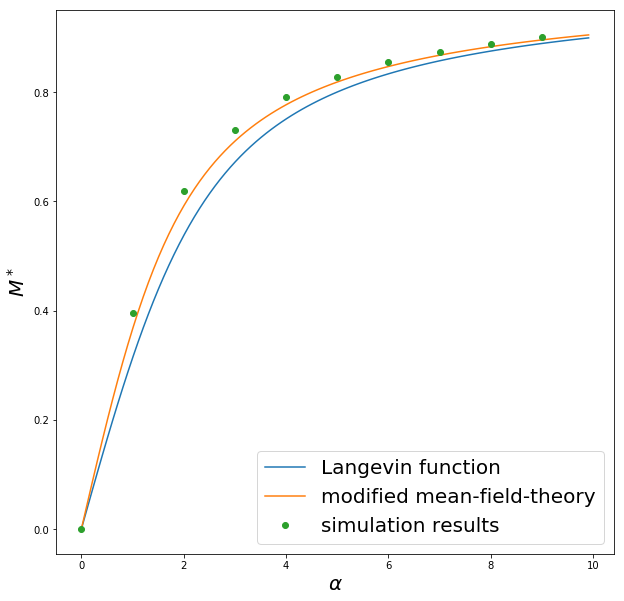

In [17]:
y = np.arange(0.01,10, 0.1, dtype=float).tolist()


L_func = []
L_iv = []
for i in y:
    L_func.append(L(i))
    L_iv.append(L(alpha_Ivanov(i, dip_lambda, phi)))

# devide all entries in the magnetization list by N to get the dimensionless magnetization
magnetization_star = []
for i in range(len(magnetization)):
    magnetization_star.append(magnetization[i] / N)

plt.figure(figsize=(10,10))
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel(r'$M^*$', fontsize=20)
plt.plot(y, L_func, label='Langevin function')
plt.plot(y, L_iv, label='modified mean-field-theory')
plt.plot(alphas, magnetization_star, 'o', label='simulation results')
plt.legend(fontsize=20)
plt.show()

We can see that the curve of the modified Langevin parameter is closer to our simulation results.

[1] Zuowei Wang, Christian Holm, and Hanns Walter Müller. “Molecular dynamics
study on the equilibrium magnetization properties and structure of ferrofluids”. In:
Phys. Rev. E 66 (2 Aug. 2002), p. 021405. doi: 10.1103/PhysRevE.66.021405.
url: https://link.aps.org/doi/10.1103/PhysRevE.66.021405.

[2] Alexey O. Ivanov and Olga B. Kuznetsova. “Magnetic properties of dense ferrofluids:
An influence of interparticle correlations”. In: Phys. Rev. E 64 (4 Sept. 2001),
p. 041405. doi: 10.1103/PhysRevE.64.041405. url: https://link.aps.org/
doi/10.1103/PhysRevE.64.041405.